## What properties of the conn matrices lead to observed group differences in GMs?

In [1]:
import numpy as np
import nibabel as nib
from nilearn import datasets
import os.path as op
import os
import pandas as pd


In [3]:
bids_folder = '/mnt_03/ds-dnumrisk' 
subList = [f[4:6] for f in os.listdir(bids_folder) if f[0:4] == 'sub-' and len(f) == 6]
sub_array = np.array([int(i) for i in subList])

# group list
df_participants = pd.read_csv(op.join(bids_folder, 'add_tables','subjects_recruit_scan_scanned-final.csv'), header=0) #, index_col=0
group_list = df_participants.loc[:,['subject ID','group']].rename(mapper={'subject ID': 'subject'},axis=1).dropna().astype({'subject': int, 'group': int}).set_index('subject')

source_folder = op.join(bids_folder,'derivatives','correlation_matrices')
#target_folder = op.join(bids_folder,'derivatives','gradients')

specification = ''
space = 'fsaverage'

In [95]:
from numrisk.fmri_analysis.gradients.utils import get_glasser_CAatlas_mapping,get_glasser_parcels

glasser_CAatlas_mapping, CAatlas_names = get_glasser_CAatlas_mapping()
mask_glasser, labeling_glasser = get_glasser_parcels(space = 'fsaverage5' )

from  nilearn.datasets import fetch_surf_fsaverage
fsaverage = fetch_surf_fsaverage() # default 5
import nilearn.plotting as nplt
import nibabel as nib
import matplotlib.pyplot as plt


## Top 10 connections per node

* Number of connections (per seed region) showing differences (group =sex) in their odds of belonging to the given seed’s `top 10%` connections {10 --> thresholded CM for GM fitting ? }

In [80]:
fc_strengths = []
fc_strengths_top10 = []

for sub in subList:
    cm_file = op.join(source_folder,f'sub-{sub}_glasserParcel-{space}.npy')
    cm = np.load(cm_file)

    top_10_percent_indices = []
    fc_strength_rows = []
    for row in cm: 
        top_10_ind = np.argsort(row)[-top_n:][::-1] # argsort returns indices of sorted array in ascending order, [-top_n:] takees therefore the top (here=last) 36, [::-1] reverses the array
        top_10_percent_indices.append(top_10_ind)
        fc_strength_rows.append(np.mean(row[top_10_ind]))

    top_10_percent_indices = np.array(top_10_percent_indices) # (360, 36)
    fc_strengths.append(np.sum(cm,axis=1)) # (360,)
    fc_strengths_top10.append(np.array(fc_strength_rows)) # (360,)



In [82]:
np.shape(fc_strengths_top10)

(66, 360)

In [119]:
which_connections = 'top10' # 'top10' or 'all'

fc_s = np.array(fc_strengths_top10) if which_connections == 'top10' else np.array(fc_strengths)
df = pd.DataFrame(fc_s, index=sub_array, columns = [f'parcel_{i}' for i in range(360)])
df.index.name = 'subject'
df = df.join(group_list).set_index('group',append=True)


In [120]:
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

tmp = df
group_0 = tmp.xs(0,0,'group')
group_1 = tmp.xs(1,0,'group')

t_stats, p_values = ttest_ind(group_0, group_1, axis=0, equal_var=False)
corrected_p_values = multipletests(p_values, method='fdr_bh')[1] 
print(len(p_values))

360


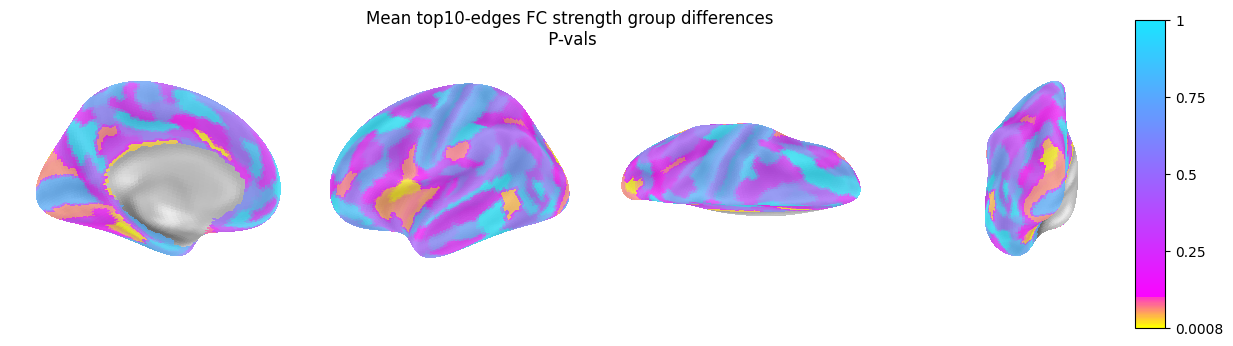

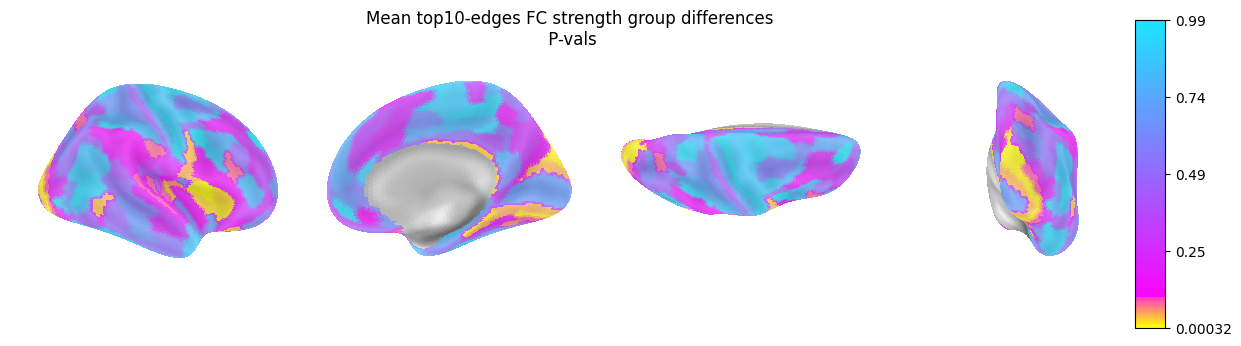

In [121]:
from brainspace.utils.parcellation import map_to_labels
from numrisk.fmri_analysis.gradients.utils_02 import get_pval_colormap

pval_cmap = get_pval_colormap()
views = ['medial','lateral','dorsal','posterior']

#if resolution == 'parcel':
stats_fsav5 = map_to_labels(p_values, labeling_glasser, mask=mask_glasser, fill=np.nan) # parcel to vertex


for i, hemi in enumerate(['L','R']):
    map = np.split(stats_fsav5,2)[i]
    surf_mesh = fsaverage.infl_right if hemi =='R' else fsaverage.infl_left
    bg_map = fsaverage.sulc_right if hemi =='R' else fsaverage.sulc_left

    figure, axes = plt.subplots(nrows=1, ncols=len(views),figsize = (15,8), subplot_kw=dict(projection='3d'))
    for i,view in enumerate(views):
        colbar = True if view == 'posterior' else False
        nplt.plot_surf(surf_mesh=surf_mesh , surf_map= map, # infl_right # pial_right
                view= view,cmap=pval_cmap, colorbar=colbar, #title=f'sub-{sub}, grad {n_grad+1}',
                bg_map=bg_map, bg_on_data=True,darkness=0.7, axes=axes[i]) 
    figure.subplots_adjust(wspace=0.01)
    figure.suptitle(f'Mean {which_connections}-edges FC strength group differences \n P-vals ', y=0.7)

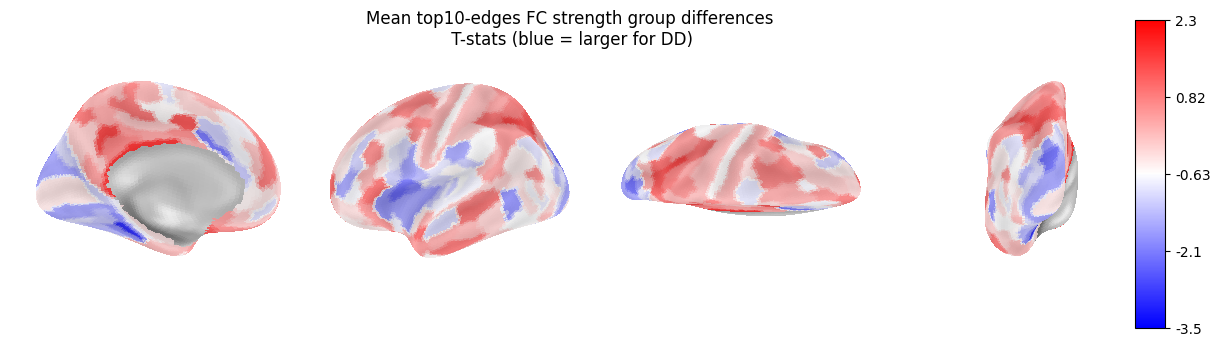

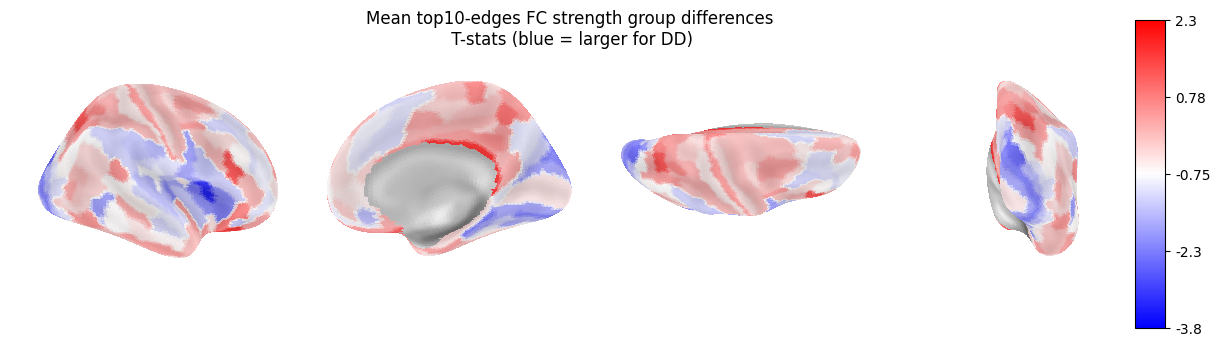

In [122]:
tstat_cmap = 'bwr'
views = ['medial','lateral','dorsal','posterior']

#if resolution == 'parcel':
stats_fsav5 = map_to_labels(t_stats, labeling_glasser, mask=mask_glasser, fill=np.nan) # parcel to vertex
p_values_fsav5 = map_to_labels(p_values, labeling_glasser, mask=mask_glasser, fill=np.nan) # parcel to vertex
#stats_fsav5[p_values_fsav5 > 0.05] = np.nan

for i, hemi in enumerate(['L','R']):
    map = np.split(stats_fsav5,2)[i]
    surf_mesh = fsaverage.infl_right if hemi =='R' else fsaverage.infl_left
    bg_map = fsaverage.sulc_right if hemi =='R' else fsaverage.sulc_left

    figure, axes = plt.subplots(nrows=1, ncols=len(views),figsize = (15,8), subplot_kw=dict(projection='3d'))
    for i,view in enumerate(views):
        colbar = True if view == 'posterior' else False
        nplt.plot_surf(surf_mesh=surf_mesh , surf_map= map, # infl_right # pial_right
                view= view,cmap=tstat_cmap, colorbar=colbar, #title=f'sub-{sub}, grad {n_grad+1}',
                bg_map=bg_map, bg_on_data=True,darkness=0.7, axes=axes[i]) 
    figure.subplots_adjust(wspace=0.01)
    figure.suptitle(f'Mean {which_connections}-edges FC strength group differences \n T-stats (blue = larger for DD) \n', y=0.7) # for p-val < 0.05


so to which regions is visual2 more connected (given that it is less so to the dorsal-attention network) ?

## Between Network connectivity strength

In [47]:
# FC strength Dorsal-Attention to Visual! (symmetric!)

# Get the boolean arrays for the networks
network_seed_indices = np.where(glasser_CAatlas_mapping['ca_network'] == 2)[0]
network_target_indices = np.where(glasser_CAatlas_mapping['ca_network'] == 5)[0]

# Use these indices to index the rows and columns of the connectivity matrix
cm_vis_dorat = cm[np.ix_(network_seed_indices, network_target_indices)]
fc_vis_dorat_strength = np.mean(cm_vis_dorat,axis=1)
mean_fc_vis_dorat_strength = np.mean(fc_vis_dorat_strength) 
mean_fc_vis_dorat_strength

0.17998827380455082

In [ ]:
network_2_indices = np.where(glasser_CAatlas_mapping['ca_network'] == 2)[0]
network_5_indices = np.where(glasser_CAatlas_mapping['ca_network'] == 5)[0]

mean_fc_vis_dorat_strengths = []
for sub in subList:
    cm_file = op.join(source_folder,f'sub-{sub}_glasserParcel-{space}.npy')
    cm = np.load(cm_file)

    cm_vis_dorat = cm[np.ix_(network_2_indices, network_5_indices)]
    fc_vis_dorat_strength = np.mean(cm_vis_dorat,axis=1)
    mean_fc_vis_dorat_strength = np.mean(fc_vis_dorat_strength) 
    mean_fc_vis_dorat_strengths.append(mean_fc_vis_dorat_strength)


sub_array = np.array([int(i) for i in subList])
df = pd.DataFrame(np.array(mean_fc_vis_dorat_strengths), index=sub_array, columns=['mean_fc_vis_dorat_strength'])
df.index.name = 'subject'
df = df.join(group_list).set_index('group',append=True)


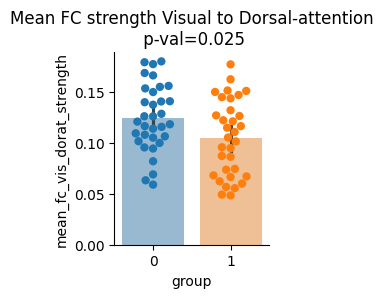

In [62]:
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt

y_var = 'mean_fc_vis_dorat_strength' #  'NPC_centroid'

tmp = df.copy()

figure, axes = plt.subplots(1, 1,figsize = (2,2.5))
sns.barplot(data=tmp.reset_index(), x ='group', hue='group',y=y_var, alpha=0.5,legend=False)
sns.swarmplot(data=tmp.reset_index(),  x ='group', hue='group',y=y_var, size=6,legend=False)
t_stats, p_values = ttest_ind(tmp.xs(0,0,'group')[y_var], tmp.xs(1,0,'group')[y_var], axis=0, equal_var=False)
p_val = np.round(p_values,3)

axes.set(title=f'Mean FC strength Visual to Dorsal-attention\n p-val={p_val}',ylabel=y_var, xlabel='group')
sns.despine()

In [ ]:
# Get the boolean arrays for the networks
fc_strengths = []
fc_strengths_top10 = []


for sub in subList:
    cm_file = op.join(source_folder,f'sub-{sub}_glasserParcel-{space}.npy')
    cm = np.load(cm_file)

    for seed_net in np.unique(glasser_CAatlas_mapping['ca_network']):
        for target_net in np.unique(glasser_CAatlas_mapping['ca_network']):
            network_seed_indices = np.where(glasser_CAatlas_mapping['ca_network'] == seed_net)[0]
            network_target_indices = np.where(glasser_CAatlas_mapping['ca_network'] == target_net)[0]

            # Use these indices to index the rows and columns of the connectivity matrix
            cm_fil = cm[np.ix_(network_seed_indices, network_target_indices)]
            fc_cm_fil = np.mean(cm_fil,axis=1)
            mean_fc_cm_fil = np.mean(fc_cm_fil) 


In [125]:
CMs= [None] * len(subList)

for i,sub in enumerate(subList):
    cm_file = op.join(source_folder,f'sub-{sub}_glasserParcel-{space}.npy')
    cm = np.load(cm_file)
    CMs[i] = cm

CMs = np.array(CMs)
np.shape(CMs)

(66, 360, 360)

In [131]:
network_seed_indices

array([  0, 120, 141, 180, 300, 321])

In [133]:
network_seed_indices = np.where(glasser_CAatlas_mapping['ca_network'] == 1)[0]
network_target_indices = np.where(glasser_CAatlas_mapping['ca_network'] == 2)[0]

cm = CMs[i]
np.shape(cm)

(360, 360)

In [147]:
N_nets = 12

mat_tstat = np.zeros([N_nets, N_nets])
mat_pvals = np.ones([N_nets, N_nets])

for seed_net in np.unique(glasser_CAatlas_mapping['ca_network']):
    for target_net in np.unique(glasser_CAatlas_mapping['ca_network']):
        network_seed_indices = np.where(glasser_CAatlas_mapping['ca_network'] == seed_net)[0]
        network_target_indices = np.where(glasser_CAatlas_mapping['ca_network'] == target_net)[0]

        mean_BN_fc_strength = []
        for i,sub in enumerate(subList):
            cm = CMs[i]
            cm_fil = cm[np.ix_(network_seed_indices, network_target_indices)]
            #fc_cm_fil = np.mean(cm_fil,axis=1)
            mean_fc_cm_fil = np.mean(np.mean(cm_fil,axis=1)) 
            mean_BN_fc_strength.append(mean_fc_cm_fil)
        
        df = pd.DataFrame(np.array(mean_BN_fc_strength), index=sub_array)
        df.index.name = 'subject'
        df = df.join(group_list).set_index('group',append=True)
        t_stat, p_val = ttest_ind(df.xs(0,0,'group'), df.xs(1,0,'group'), equal_var=False)  # Welch's t-test

        mat_tstat[seed_net-1,target_net-1] = t_stat[0]
        mat_pvals[seed_net-1,target_net-1] = np.round(p_val, 3)



/tmp/ipykernel_3696346/2334525620.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mat_pvals[seed_net-1,target_net-1] = np.round(p_val, 3)
/tmp/ipykernel_3696346/2334525620.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mat_pvals[seed_net-1,target_net-1] = np.round(p_val, 3)
/tmp/ipykernel_3696346/2334525620.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mat_pvals[seed_net-1,target_net-1] = np.round(p_val, 3)
/tmp/ipykernel_3696346/2334525620.py:25:

Text(0.5, 1.1, 'Between network FC strength (T-stat)')

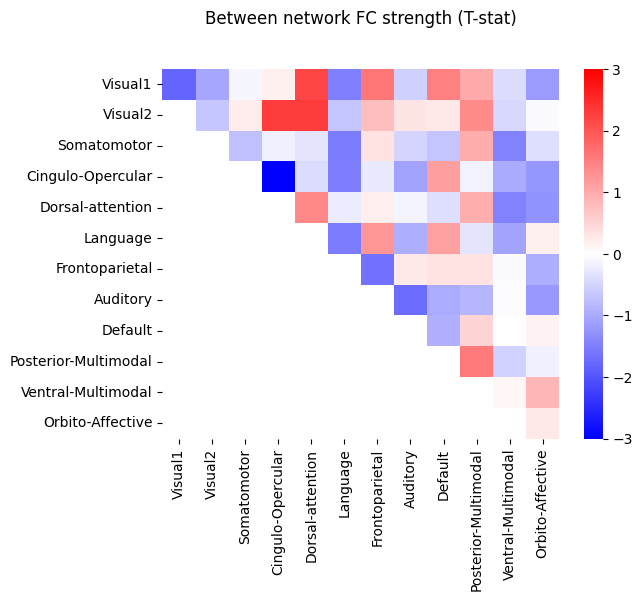

In [165]:
mat_tstat_ = mat_tstat.copy()
mat_tstat_[np.tril_indices_from(mat_tstat, k=-1)] = 0

sns.heatmap(mat_tstat_, cmap='bwr',vmin=-3,vmax=3,
            xticklabels=[str(CAatlas_names.loc[i+1]['Network Name']) for i in range(N_nets)],
            yticklabels=[str(CAatlas_names.loc[i+1]['Network Name']) for i in range(N_nets)])
plt.title(f'Between network FC strength (T-stat)' , y=1.1)

Text(0.5, 1.02, 'P-vals of between group TTEst on between network FC strength')

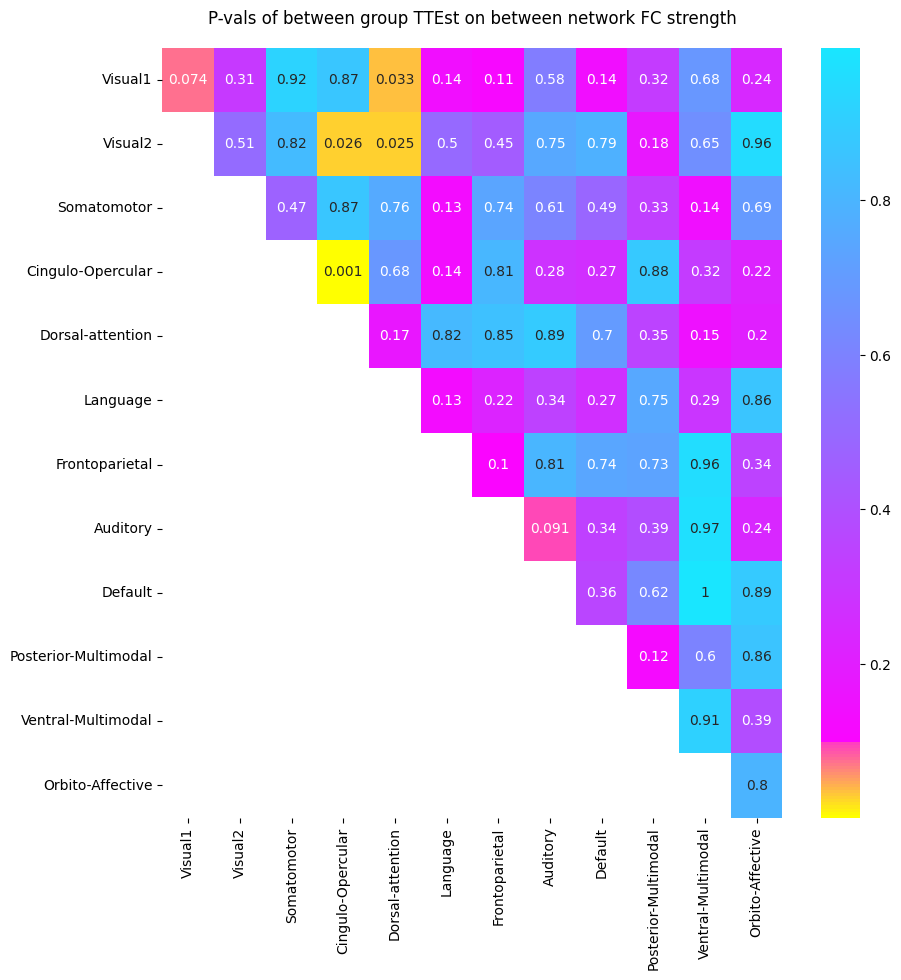

In [163]:
pval_cmap = get_pval_colormap()

mat_pvals_ = mat_pvals.copy()
mat_pvals_[np.tril_indices_from(mat_pvals_, k=-1)] = np.nan

fig, axes = plt.subplots(1,1, figsize=(10,10)) # , sharex=True, sharey=True
sns.heatmap(mat_pvals_, cmap=pval_cmap,annot=True,ax=axes, #vmin=-0.4,vmax=0.4,
            xticklabels=[str(CAatlas_names.loc[i+1]['Network Name']) for i in range(N_nets)],
            yticklabels=[str(CAatlas_names.loc[i+1]['Network Name']) for i in range(N_nets)])
plt.title(f'P-vals of between group TTEst on between network FC strength', y=1.02)

## FC strength

mean FC strength